In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s6e2/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s6e2/test.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s6e2/sample_submission.csv')

df_sample.head()

,id,Heart Disease
0,630000,0
1,630001,0
2,630002,0
3,630003,0
4,630004,0


In [3]:
X = df_train.drop(columns=['id', 'Heart Disease'])
y = df_train['Heart Disease']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

cat_features = X_train.select_dtypes(include='object').columns
num_features = X_train.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(
            handle_unknown='ignore',
            sparse_output=False
        ), cat_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_distributions = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    pipeline,
    n_iter=10,
    n_jobs=5,
    cv=cv,
    random_state=42,
    scoring = 'roc_auc',
    param_distributions=param_distributions,
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

y_proba = best_model.predict_proba(X_val)[:, 1]
threshold = 0.35
y_pred = (y_proba >= threshold).astype(int)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


              precision    recall  f1-score   support

  No Disease      0.934     0.818     0.872     69509
     Disease      0.806     0.929     0.863     56491

    accuracy                          0.868    126000
   macro avg      0.870     0.874     0.868    126000
weighted avg      0.877     0.868     0.868    126000



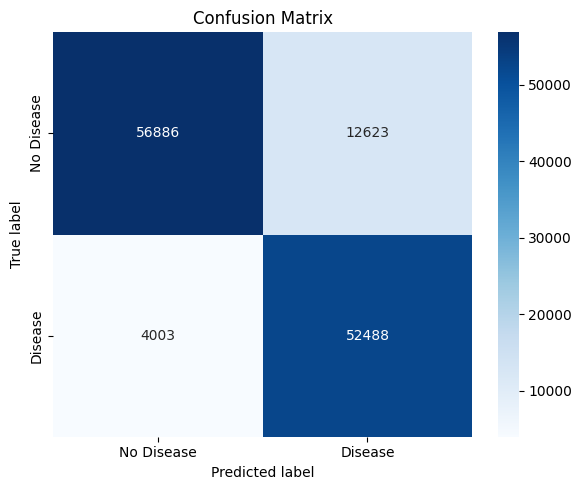

In [4]:
y_val_formatted=y_val.map({'Absence': 0, 'Presence': 1})

cr = classification_report(
        y_val_formatted,
        y_pred,
        target_names=['No Disease', 'Disease'],
        digits=3
    )

print(cr)

cm=confusion_matrix(y_val_formatted, y_pred)

cm = confusion_matrix(y_val_formatted, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Disease', 'Disease'],
    yticklabels=['No Disease', 'Disease']
)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [5]:
best_model.fit(X, y)
test_ids = df_test['id']
X_test = df_test.drop(columns=['id'])

In [6]:
test_proba = best_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'id': test_ids,
    'Heart Disease': test_proba
})

submission.to_csv("submission.csv", index=False)